In [1]:
import tone
import utils
from utils import *

tone.utils.ipython.autoreload(utils)
tone.utils.learning.ignore_warning()
device = tone.utils.learning.try_use_device()
device

device(type='cuda')

In [2]:
pts = glob.glob("models/*.pt")
models = []
for pt in pts:
    model = tone.utils.learning.load_pickle(pt)
    models.append(model)

models.append(utils.ETS())
models.append(utils.ARIMA())

100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


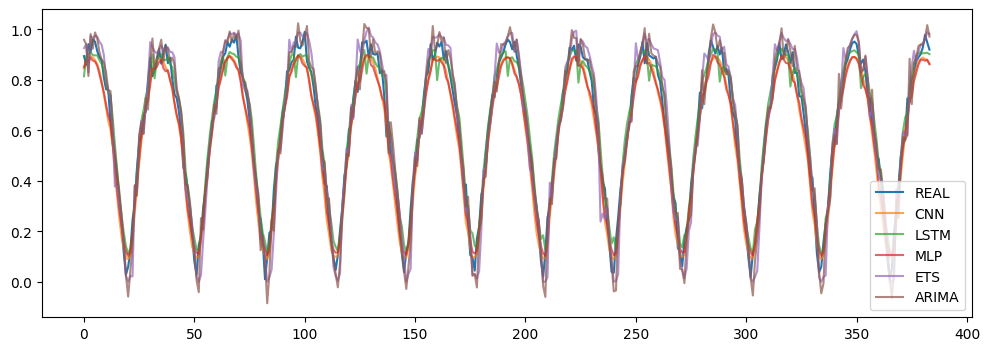

In [3]:
lags = 12
batch_size = 16

dataset = utils.SineDataset(lags, train=False, len=400)

real, preds = utils.test(models, dataset, batch_size, device, progress=True)


fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(real.detach().cpu(), label='REAL')
for i, pred in enumerate(preds):
    ax.plot(pred.detach().cpu(), alpha=0.7, label=f'{type(models[i]).__name__}')

plt.legend()
plt.show()
plt.close()


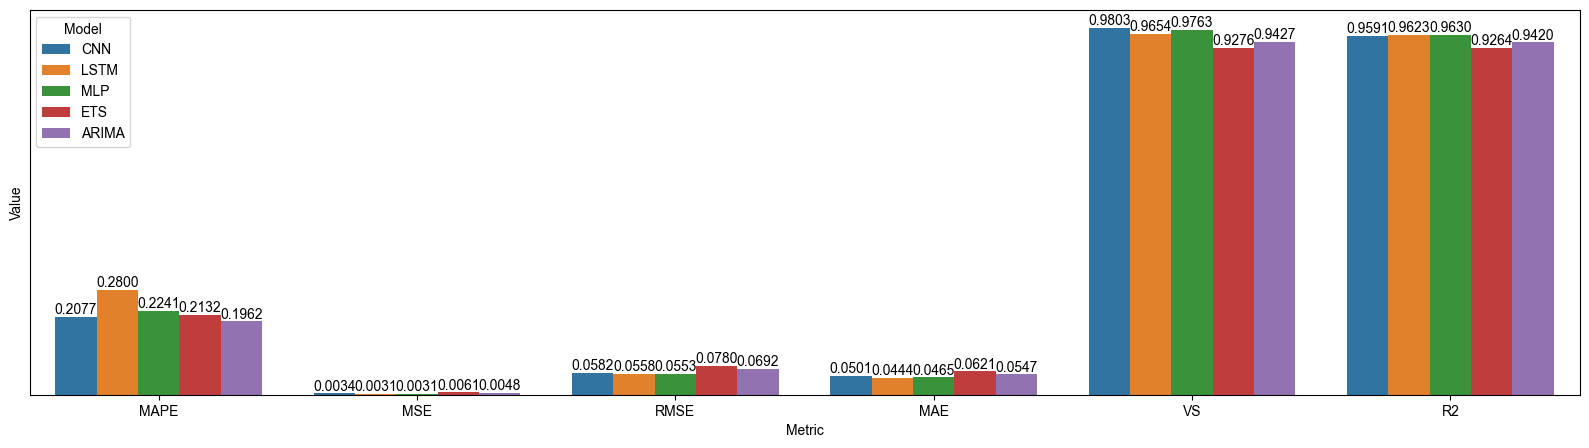

,Metric,CNN,LSTM,MLP,ETS,ARIMA
0,MAPE,0.207697,0.279967,0.224129,0.213171,0.196241
1,MSE,0.003383,0.003116,0.003055,0.006078,0.004790
2,RMSE,0.058165,0.055820,0.055270,0.077959,0.069212
3,MAE,0.050119,0.044423,0.046517,0.062124,0.054714
4,VS,0.980309,0.965368,0.976332,0.927561,0.942721
5,R2,0.959053,0.962288,0.963026,0.926440,0.942021


In [4]:
df = pd.DataFrame()
data = []

for i, model in enumerate(models):
    name = type(model).__name__

    m = tone.utils.learning.metrics(
        real.detach().cpu().numpy(),
        preds[i].detach().cpu().numpy()
    )

    df['Metric'] = [key.upper() for key in m.keys()]
    df[name] = m.values()

    for key, value in m.items():
        data.append([name, key.upper(), value])

data = pd.DataFrame(data, columns=['Model', 'Metric', 'Value'])

fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot(data, x='Metric', y='Value', hue='Model', ax=ax)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f')
ax.set_yticks([])
sns.set_style('darkgrid')
plt.show()

df